In [ ]:
# mount drive

from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My\ Drive/CSE493G1/project

Mounted at /content/drive/
/content/drive/My Drive/CSE493G1/project


In [ ]:
# Core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from pathlib import Path
import numpy as np


# --- paths & hyper-params ---
DATA_DIR      = Path("oatmeal_data")
BATCH_SIZE    = 32
NUM_EPOCHS    = 20
LR_HEAD       = 3e-4                    # head / classifier
LR_BACKBONE   = 1e-4                    # after unfreeze

In [ ]:
import os

new_classes = ['off', 'safe', 'unsafe']

def load_dataset(data_dir):
    # Assumes images are 224x224 and stored as data_dir/{class}/{vid}/{frame}.png
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet mean
            std =[0.229, 0.224, 0.225]   # ImageNet std
        )
    ])

    full_ds = datasets.ImageFolder(data_dir, transform=transform)

    # Split into train and val by video folder
    def get_datatset(path):
        parts = path.split(os.sep)
        if len(parts) >= 3:
            try:
                vid = int(parts[-2])
                if vid < 19:
                  return 'train'
                elif vid < 30:
                  return 'val'
                else:
                  return 'test'
            except ValueError:
                return False
        return False

    train_samples = [s for s in full_ds.samples if not get_datatset(s[0]) == 'train']
    val_samples = [s for s in full_ds.samples if get_datatset(s[0]) == 'val']
    test_samples = [s for s in full_ds.samples if get_datatset(s[0]) == 'test']

    print(f"Train samples: {len(train_samples)}  Val samples: {len(val_samples)} Test samples: {len(test_samples)}")

    # Create train and val subsets
    train_ds = datasets.ImageFolder(data_dir, transform=transform)
    train_ds.samples = train_samples
    train_ds.targets = [s[1] for s in train_samples]

    val_ds = datasets.ImageFolder(data_dir, transform=transform)
    val_ds.samples = val_samples
    val_ds.targets = [s[1] for s in val_samples]

    test_ds = datasets.ImageFolder(data_dir, transform=transform)
    test_ds.samples = test_samples
    test_ds.targets = [s[1] for s in test_samples]

    return train_ds, val_ds, test_ds


In [ ]:
train_ds, val_ds, test_ds = load_dataset(DATA_DIR)

train_class_counts  = np.bincount(train_ds.targets, minlength=3)
print("Training samples per class:", dict(zip(train_ds.classes, train_class_counts)))

val_class_counts  = np.bincount(val_ds.targets, minlength=3)
print("Validation samples per class", dict(zip(val_ds.classes, val_class_counts)))

test_class_counts  = np.bincount(test_ds.targets, minlength=3)
print("Test samples per class", dict(zip(test_ds.classes, test_class_counts)))

train_class_weights = 1.0 / train_class_counts
train_class_weights[new_classes.index('unsafe')] *= 10
train_sample_weights = [train_class_weights[t] for t in train_ds.targets]
train_sampler = WeightedRandomSampler(
    weights      = train_sample_weights,
    num_samples  = len(train_sample_weights),
    replacement  = True
)

# --- rebuild DataLoaders ----------------------------------------------------
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

Train samples: 783  Val samples: 596 Test samples: 187
Training samples per class: {'off': np.int64(60), 'safe': np.int64(660), 'unsafe': np.int64(63)}
Validation samples per class {'off': np.int64(54), 'safe': np.int64(488), 'unsafe': np.int64(54)}
Test samples per class {'off': np.int64(6), 'safe': np.int64(172), 'unsafe': np.int64(9)}


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=[1, 1, 3], gamma=2):
        super().__init__()
        self.alpha = torch.tensor(alpha).to(device)
        self.gamma = gamma
    def forward(self, logits, targets):
        ce = nn.functional.cross_entropy(logits, targets, reduction="none")
        pt = torch.exp(-ce)
        return (self.alpha[targets] * (1-pt)**self.gamma * ce).mean()

In [ ]:
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

model = models.mobilenet_v3_small(pretrained=True)

model.classifier[3] = nn.Linear(in_features=1024, out_features=len(new_classes))
# initilize weights
# nn.init.xavier_uniform_(model.classifier[3].weight)
# nn.init.zeros_(model.classifier[3].bias)

model.to(device)

# # Warm-up: train head only, freeze backbone
for p in model.features.parameters():
    p.requires_grad = False

# overweight misclassifying unsafe
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0, 10.0]).to(device))
criterion = FocalLoss(alpha=[1, 1, 7], gamma=2)
optimizer = optim.AdamW(model.classifier.parameters(), lr=LR_HEAD)
scheduler = ExponentialLR(optimizer, gamma=0.95)

cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 79.9MB/s]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

def eval_on_dataset(loader, verbose=True):
  model.eval()

  all_preds, all_labels, evals = [], [], []

  with torch.no_grad():
    for inputs, labels in loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      all_preds.append(preds.cpu())
      all_labels.append(labels.cpu())
      evals.append((inputs.cpu(), preds.cpu(), labels.cpu()))

  all_preds  = torch.cat(all_preds).numpy()
  all_labels = torch.cat(all_labels).numpy()

  safe_accuracy = np.mean(all_preds[all_labels == 1] == all_labels[all_labels == 1])
  unsafe_accuracy = np.mean(all_preds[all_labels == 2] == all_labels[all_labels == 2])
  accuracies = {}
  accuracies['safe'] = safe_accuracy
  accuracies['unsafe'] = unsafe_accuracy

  if verbose:
    # confusion matrix & classification report
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion matrix (rows=true, cols=pred):\n", cm, "\n")
    print(classification_report(all_labels, all_preds, target_names=new_classes))

    # mis-classification counts by true class
    mis_mask   = all_preds != all_labels
    mis_counts = np.bincount(all_labels[mis_mask], minlength=len(new_classes))
    print("\nMis-classified sample count per true class:")
    for cls, n in zip(new_classes, mis_counts):
      print(f"{cls:>12}: {n}")

  return evals, accuracies



In [ ]:
head_epoch = 0
head_terminal_val_accuracy_safe = 0.75
head_terminal_val_accuracy_unsafe = 0.75
while True:
  model.train()
  running_loss = 0.0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  scheduler.step()

  avg_loss = running_loss / len(train_loader)
  _, val_accuracies = eval_on_dataset(val_loader)
  print(f"Epoch [{head_epoch+1}]  train-loss: {avg_loss:.4f} val-acc-safe {val_accuracies['safe']:.4f} val-acc-unsafe {val_accuracies['unsafe']:.4f}")

  head_epoch += 1
  if head_epoch > 10 and val_accuracies['safe'] > head_terminal_val_accuracy_safe and val_accuracies['unsafe'] > head_terminal_val_accuracy_unsafe:
    break

Confusion matrix (rows=true, cols=pred):
 [[ 47   0   7]
 [138 165 185]
 [ 11  25  18]] 

              precision    recall  f1-score   support

         off       0.24      0.87      0.38        54
        safe       0.87      0.34      0.49       488
      unsafe       0.09      0.33      0.14        54

    accuracy                           0.39       596
   macro avg       0.40      0.51      0.33       596
weighted avg       0.74      0.39      0.44       596


Mis-classified sample count per true class:
         off: 7
        safe: 323
      unsafe: 36
Epoch [1]  train-loss: 0.4623 val-acc-safe 0.3381 val-acc-unsafe 0.3333


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 53   0   1]
 [ 20 374  94]
 [  2  36  16]] 

              precision    recall  f1-score   support

         off       0.71      0.98      0.82        54
        safe       0.91      0.77      0.83       488
      unsafe       0.14      0.30      0.19        54

    accuracy                           0.74       596
   macro avg       0.59      0.68      0.62       596
weighted avg       0.82      0.74      0.77       596


Mis-classified sample count per true class:
         off: 1
        safe: 114
      unsafe: 38
Epoch [2]  train-loss: 0.0961 val-acc-safe 0.7664 val-acc-unsafe 0.2963


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  2 277 209]
 [  0  21  33]] 

              precision    recall  f1-score   support

         off       0.96      1.00      0.98        54
        safe       0.93      0.57      0.70       488
      unsafe       0.14      0.61      0.22        54

    accuracy                           0.61       596
   macro avg       0.68      0.73      0.64       596
weighted avg       0.86      0.61      0.69       596


Mis-classified sample count per true class:
         off: 0
        safe: 211
      unsafe: 21
Epoch [3]  train-loss: 0.0592 val-acc-safe 0.5676 val-acc-unsafe 0.6111


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  1 163 324]
 [  0   3  51]] 

              precision    recall  f1-score   support

         off       0.98      1.00      0.99        54
        safe       0.98      0.33      0.50       488
      unsafe       0.14      0.94      0.24        54

    accuracy                           0.45       596
   macro avg       0.70      0.76      0.58       596
weighted avg       0.91      0.45      0.52       596


Mis-classified sample count per true class:
         off: 0
        safe: 325
      unsafe: 3
Epoch [4]  train-loss: 0.0512 val-acc-safe 0.3340 val-acc-unsafe 0.9444


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  1 196 291]
 [  0   4  50]] 

              precision    recall  f1-score   support

         off       0.98      1.00      0.99        54
        safe       0.98      0.40      0.57       488
      unsafe       0.15      0.93      0.25        54

    accuracy                           0.50       596
   macro avg       0.70      0.78      0.60       596
weighted avg       0.90      0.50      0.58       596


Mis-classified sample count per true class:
         off: 0
        safe: 292
      unsafe: 4
Epoch [5]  train-loss: 0.0390 val-acc-safe 0.4016 val-acc-unsafe 0.9259


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  1 287 200]
 [  0   9  45]] 

              precision    recall  f1-score   support

         off       0.98      1.00      0.99        54
        safe       0.97      0.59      0.73       488
      unsafe       0.18      0.83      0.30        54

    accuracy                           0.65       596
   macro avg       0.71      0.81      0.67       596
weighted avg       0.90      0.65      0.72       596


Mis-classified sample count per true class:
         off: 0
        safe: 201
      unsafe: 9
Epoch [6]  train-loss: 0.0270 val-acc-safe 0.5881 val-acc-unsafe 0.8333


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  1 383 104]
 [  0  19  35]] 

              precision    recall  f1-score   support

         off       0.98      1.00      0.99        54
        safe       0.95      0.78      0.86       488
      unsafe       0.25      0.65      0.36        54

    accuracy                           0.79       596
   macro avg       0.73      0.81      0.74       596
weighted avg       0.89      0.79      0.83       596


Mis-classified sample count per true class:
         off: 0
        safe: 105
      unsafe: 19
Epoch [7]  train-loss: 0.0316 val-acc-safe 0.7848 val-acc-unsafe 0.6481


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  1 419  68]
 [  0  25  29]] 

              precision    recall  f1-score   support

         off       0.98      1.00      0.99        54
        safe       0.94      0.86      0.90       488
      unsafe       0.30      0.54      0.38        54

    accuracy                           0.84       596
   macro avg       0.74      0.80      0.76       596
weighted avg       0.89      0.84      0.86       596


Mis-classified sample count per true class:
         off: 0
        safe: 69
      unsafe: 25
Epoch [8]  train-loss: 0.0285 val-acc-safe 0.8586 val-acc-unsafe 0.5370


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  2 419  67]
 [  2  21  31]] 

              precision    recall  f1-score   support

         off       0.93      1.00      0.96        54
        safe       0.95      0.86      0.90       488
      unsafe       0.32      0.57      0.41        54

    accuracy                           0.85       596
   macro avg       0.73      0.81      0.76       596
weighted avg       0.89      0.85      0.86       596


Mis-classified sample count per true class:
         off: 0
        safe: 69
      unsafe: 23
Epoch [9]  train-loss: 0.0222 val-acc-safe 0.8586 val-acc-unsafe 0.5741


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [ 11 422  55]
 [  5  19  30]] 

              precision    recall  f1-score   support

         off       0.77      1.00      0.87        54
        safe       0.96      0.86      0.91       488
      unsafe       0.35      0.56      0.43        54

    accuracy                           0.85       596
   macro avg       0.69      0.81      0.74       596
weighted avg       0.89      0.85      0.86       596


Mis-classified sample count per true class:
         off: 0
        safe: 66
      unsafe: 24
Epoch [10]  train-loss: 0.0162 val-acc-safe 0.8648 val-acc-unsafe 0.5556


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  2 435  51]
 [  1  24  29]] 

              precision    recall  f1-score   support

         off       0.95      1.00      0.97        54
        safe       0.95      0.89      0.92       488
      unsafe       0.36      0.54      0.43        54

    accuracy                           0.87       596
   macro avg       0.75      0.81      0.77       596
weighted avg       0.89      0.87      0.88       596


Mis-classified sample count per true class:
         off: 0
        safe: 53
      unsafe: 25
Epoch [11]  train-loss: 0.0174 val-acc-safe 0.8914 val-acc-unsafe 0.5370


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  2 448  38]
 [  0  27  27]] 

              precision    recall  f1-score   support

         off       0.96      1.00      0.98        54
        safe       0.94      0.92      0.93       488
      unsafe       0.42      0.50      0.45        54

    accuracy                           0.89       596
   macro avg       0.77      0.81      0.79       596
weighted avg       0.90      0.89      0.89       596


Mis-classified sample count per true class:
         off: 0
        safe: 40
      unsafe: 27
Epoch [12]  train-loss: 0.0108 val-acc-safe 0.9180 val-acc-unsafe 0.5000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  2 451  35]
 [  0  27  27]] 

              precision    recall  f1-score   support

         off       0.96      1.00      0.98        54
        safe       0.94      0.92      0.93       488
      unsafe       0.44      0.50      0.47        54

    accuracy                           0.89       596
   macro avg       0.78      0.81      0.79       596
weighted avg       0.90      0.89      0.90       596


Mis-classified sample count per true class:
         off: 0
        safe: 37
      unsafe: 27
Epoch [13]  train-loss: 0.0084 val-acc-safe 0.9242 val-acc-unsafe 0.5000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  2 429  57]
 [  0  20  34]] 

              precision    recall  f1-score   support

         off       0.96      1.00      0.98        54
        safe       0.96      0.88      0.92       488
      unsafe       0.37      0.63      0.47        54

    accuracy                           0.87       596
   macro avg       0.76      0.84      0.79       596
weighted avg       0.90      0.87      0.88       596


Mis-classified sample count per true class:
         off: 0
        safe: 59
      unsafe: 20
Epoch [14]  train-loss: 0.0109 val-acc-safe 0.8791 val-acc-unsafe 0.6296


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  1 437  50]
 [  0  22  32]] 

              precision    recall  f1-score   support

         off       0.98      1.00      0.99        54
        safe       0.95      0.90      0.92       488
      unsafe       0.39      0.59      0.47        54

    accuracy                           0.88       596
   macro avg       0.77      0.83      0.79       596
weighted avg       0.90      0.88      0.89       596


Mis-classified sample count per true class:
         off: 0
        safe: 51
      unsafe: 22
Epoch [15]  train-loss: 0.0101 val-acc-safe 0.8955 val-acc-unsafe 0.5926


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  1 430  57]
 [  0  20  34]] 

              precision    recall  f1-score   support

         off       0.98      1.00      0.99        54
        safe       0.96      0.88      0.92       488
      unsafe       0.37      0.63      0.47        54

    accuracy                           0.87       596
   macro avg       0.77      0.84      0.79       596
weighted avg       0.91      0.87      0.88       596


Mis-classified sample count per true class:
         off: 0
        safe: 58
      unsafe: 20
Epoch [16]  train-loss: 0.0078 val-acc-safe 0.8811 val-acc-unsafe 0.6296


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  1 424  63]
 [  0  19  35]] 

              precision    recall  f1-score   support

         off       0.98      1.00      0.99        54
        safe       0.96      0.87      0.91       488
      unsafe       0.36      0.65      0.46        54

    accuracy                           0.86       596
   macro avg       0.77      0.84      0.79       596
weighted avg       0.90      0.86      0.88       596


Mis-classified sample count per true class:
         off: 0
        safe: 64
      unsafe: 19
Epoch [17]  train-loss: 0.0079 val-acc-safe 0.8689 val-acc-unsafe 0.6481


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  1 424  63]
 [  0  20  34]] 

              precision    recall  f1-score   support

         off       0.98      1.00      0.99        54
        safe       0.95      0.87      0.91       488
      unsafe       0.35      0.63      0.45        54

    accuracy                           0.86       596
   macro avg       0.76      0.83      0.78       596
weighted avg       0.90      0.86      0.88       596


Mis-classified sample count per true class:
         off: 0
        safe: 64
      unsafe: 20
Epoch [18]  train-loss: 0.0105 val-acc-safe 0.8689 val-acc-unsafe 0.6296


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  1 407  80]
 [  0  14  40]] 

              precision    recall  f1-score   support

         off       0.98      1.00      0.99        54
        safe       0.97      0.83      0.90       488
      unsafe       0.33      0.74      0.46        54

    accuracy                           0.84       596
   macro avg       0.76      0.86      0.78       596
weighted avg       0.91      0.84      0.86       596


Mis-classified sample count per true class:
         off: 0
        safe: 81
      unsafe: 14
Epoch [19]  train-loss: 0.0120 val-acc-safe 0.8340 val-acc-unsafe 0.7407


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  1 402  85]
 [  0  12  42]] 

              precision    recall  f1-score   support

         off       0.98      1.00      0.99        54
        safe       0.97      0.82      0.89       488
      unsafe       0.33      0.78      0.46        54

    accuracy                           0.84       596
   macro avg       0.76      0.87      0.78       596
weighted avg       0.91      0.84      0.86       596


Mis-classified sample count per true class:
         off: 0
        safe: 86
      unsafe: 12
Epoch [20]  train-loss: 0.0080 val-acc-safe 0.8238 val-acc-unsafe 0.7778


In [ ]:
# write the finetuned model to drive

MODEL_PATH = 'overflow_detector_v1.pt'
torch.save(model.state_dict(), MODEL_PATH)
print(f"Saved model to {MODEL_PATH}")

Saved model to overflow_detector_v1.pt


In [ ]:
MODEL_PATH = 'overflow_detector_v1.pt'
# load the model
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [ ]:
# (optional) unfreeze backbone + fine-tune a few more epochs
for p in model.features.parameters():
    p.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=LR_BACKBONE)
scheduler = ExponentialLR(optimizer, gamma=0.9)

backbone_epoch = 0
backbone_terminal_val_accuracy_safe = 0.9
backbone_terminal_val_accuracy_unsafe = 0.9

# quick fine-tune
while True:
  model.train()
  running_loss = 0.0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  _, val_accuracies = eval_on_dataset(val_loader)
  print(f"Epoch [{backbone_epoch+1}]  train-loss: {avg_loss:.4f} val-acc-safe {val_accuracies['safe']:.4f} val-acc-unsafe {val_accuracies['unsafe']:.4f}")

  backbone_epoch += 1
  if backbone_epoch > 2 and val_accuracies['safe'] > backbone_terminal_val_accuracy_safe and val_accuracies['unsafe'] > backbone_terminal_val_accuracy_unsafe:
    break

Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  1 408  79]
 [  0   3  51]] 

              precision    recall  f1-score   support

         off       0.98      1.00      0.99        54
        safe       0.99      0.84      0.91       488
      unsafe       0.39      0.94      0.55        54

    accuracy                           0.86       596
   macro avg       0.79      0.93      0.82       596
weighted avg       0.94      0.86      0.88       596


Mis-classified sample count per true class:
         off: 0
        safe: 80
      unsafe: 3
Epoch [1]  train-loss: 0.0047 val-acc-safe 0.8361 val-acc-unsafe 0.9444


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  2 456  30]
 [  0   8  46]] 

              precision    recall  f1-score   support

         off       0.96      1.00      0.98        54
        safe       0.98      0.93      0.96       488
      unsafe       0.61      0.85      0.71        54

    accuracy                           0.93       596
   macro avg       0.85      0.93      0.88       596
weighted avg       0.95      0.93      0.94       596


Mis-classified sample count per true class:
         off: 0
        safe: 32
      unsafe: 8
Epoch [2]  train-loss: 0.0095 val-acc-safe 0.9344 val-acc-unsafe 0.8519


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 54   0   0]
 [  2 440  46]
 [  0   4  50]] 

              precision    recall  f1-score   support

         off       0.96      1.00      0.98        54
        safe       0.99      0.90      0.94       488
      unsafe       0.52      0.93      0.67        54

    accuracy                           0.91       596
   macro avg       0.83      0.94      0.86       596
weighted avg       0.95      0.91      0.92       596


Mis-classified sample count per true class:
         off: 0
        safe: 48
      unsafe: 4
Epoch [3]  train-loss: 0.0033 val-acc-safe 0.9016 val-acc-unsafe 0.9259


In [ ]:
# write the finetuned model to drive

MODEL_PATH = 'overflow_detector_v1_with_backbone.pt'
torch.save(model.state_dict(), MODEL_PATH)
print(f"Saved model to {MODEL_PATH}")

Saved model to overflow_detector_v1_with_backbone.pt


In [ ]:
if model is None:
  model = models.mobilenet_v3_small(pretrained=True)
  model.classifier[3] = nn.Linear(in_features=1024, out_features=len(new_classes))

MODEL_PATH = 'overflow_detector_v1.pt'
# load the model
model.load_state_dict(torch.load(MODEL_PATH))
_ = model.eval()

In [ ]:
evals, test_accuracies = eval_on_dataset(test_loader)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[  6   0   0]
 [  0 127  45]
 [  0   0   9]] 

              precision    recall  f1-score   support

         off       1.00      1.00      1.00         6
        safe       1.00      0.74      0.85       172
      unsafe       0.17      1.00      0.29         9

    accuracy                           0.76       187
   macro avg       0.72      0.91      0.71       187
weighted avg       0.96      0.76      0.83       187


Mis-classified sample count per true class:
         off: 0
        safe: 45
      unsafe: 0


In [ ]:
if model is None:
  model = models.mobilenet_v3_small(pretrained=True)
  model.classifier[3] = nn.Linear(in_features=1024, out_features=len(new_classes))

MODEL_PATH = 'overflow_detector_v1_with_backbone.pt'
# load the model
model.load_state_dict(torch.load(MODEL_PATH))
_ = model.eval()

In [ ]:
evals, test_accuracies = eval_on_dataset(test_loader)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[  6   0   0]
 [  1 132  39]
 [  0   0   9]] 

              precision    recall  f1-score   support

         off       0.86      1.00      0.92         6
        safe       1.00      0.77      0.87       172
      unsafe       0.19      1.00      0.32         9

    accuracy                           0.79       187
   macro avg       0.68      0.92      0.70       187
weighted avg       0.96      0.79      0.84       187


Mis-classified sample count per true class:
         off: 0
        safe: 40
      unsafe: 0


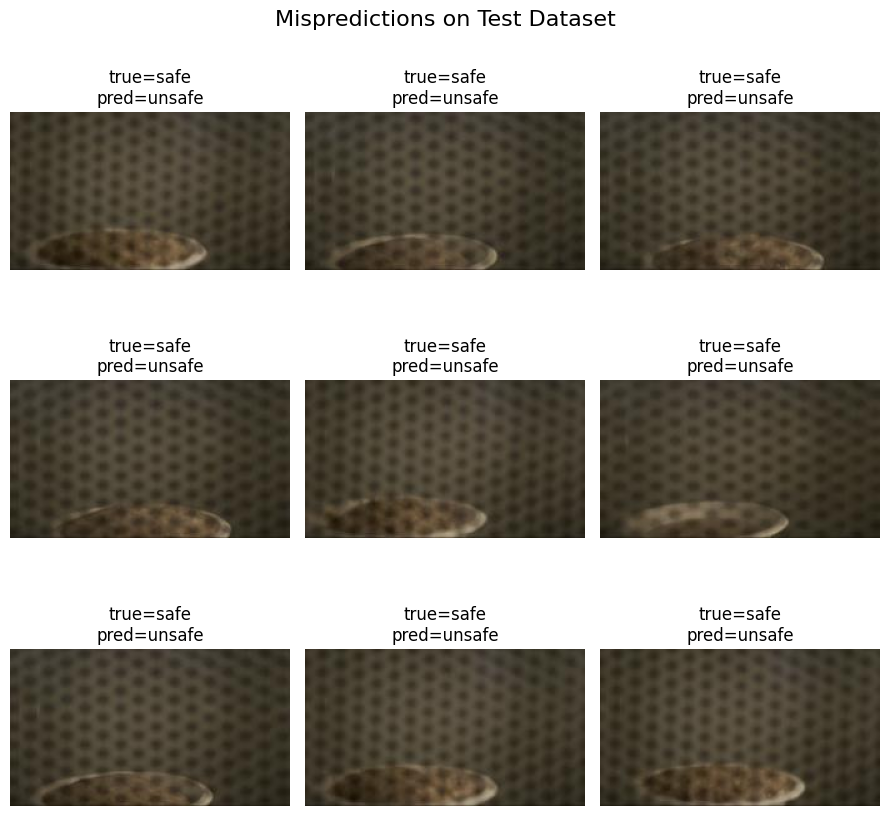

In [ ]:
import matplotlib.pyplot as plt
import random


def unnormalize_tensor(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return tensor * std + mean

# flatten evals into a list of (img, pred, true)
mis = []
for inputs, preds, labels in evals:
    for img, pred, true in zip(inputs, preds, labels):
        if pred.item() != true.item():
            mis.append((img, pred.item(), true.item()))

# how many to plot
N = 9
mis = random.sample(mis, min(N, len(mis)))
# set up the figure
cols = min(N, 3)
rows = (len(mis) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
axes = axes.flatten()

for ax, (img, pred, true) in zip(axes, mis):
    # if you normalized your inputs, undo it here; else skip:
    # img = unnormalize(img).permute(1,2,0).numpy()
    img_np = unnormalize_tensor(img).permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    ax.set_title(f"true={new_classes[true]}\npred={new_classes[pred]}")
    ax.axis('off')

# hide any extra axes
for ax in axes[len(mis):]:
    ax.axis('off')
fig.suptitle("Mispredictions on Test Dataset", fontsize=16)

plt.tight_layout()
plt.show()
